In [53]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [89]:
dataset_50y = TSD(categories=['sc'], file_path="../datasets/50_yr_dataset.csv")
dataset_50y.scv_imputed = pd.DataFrame()
dataset_50y.scv['Hierarchy_sq'] = dataset_50y.scv['Hierarchy'].apply(lambda x: x**2)

Dataset loaded from ../datasets/50_yr_dataset.xlsx


In [90]:
scale_cols = ['Pop','Terr','Cap','Hierarchy','Hierarchy_sq']
dataset_50y.impute_missing_values(scale_cols, use_duplicates=False)
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset_50y.impute_missing_values(non_scale_cols, use_duplicates = False)
dataset_50y.scv_imputed.dropna(subset=scale_cols+non_scale_cols, inplace=True)

In [75]:
dataset_50y.compute_PCA(cols = ['Pop','Terr','Cap'], col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols)-2,rescale=False)
category_weight = [(d, len(social_complexity_mapping[d])) for d in social_complexity_mapping]
dataset_50y.scv['Comp'] = 0
dataset_50y.scv_imputed['Comp'] = 0
for col in non_scale_cols:
    dataset_50y.scv['Comp'] += dataset_50y.scv[col]*category_weight[non_scale_cols.index(col)][1]
    dataset_50y.scv_imputed['Comp'] += dataset_50y.scv_imputed[col]*category_weight[non_scale_cols.index(col)][1]

Explained variance by each PC:
PC1: 92.59%
PC2: 5.31%
PC3: 2.10%


In [76]:
comp_mapping = {'comp_variables':{}}
for col in non_scale_cols:
    comp_mapping['comp_variables'][col] = 1
dataset_50y.scv_imputed['Comp'] = dataset_50y.scv_imputed.apply(lambda row: weighted_mean(row, comp_mapping, "comp_variables", imputation='zero'), axis=1)


In [80]:
url = "https://seshat-db.com/api/crisisdb/power-transitions/"
dataset_PT = TSD(file_path='../datasets/PT_dataset_imputed.xlsx')
pt_df = download_data(url)

Dataset loaded from ../datasets/PT_dataset_imputed.xlsx
Downloaded 3449 rows


In [88]:
analysis_vars = scale_cols + non_scale_cols + ['Comp']
for index,row in dataset_PT.scv_imputed.iterrows():
    polID = row['PolityID']
    break
for col in analysis_vars:
    print(dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed.PolityID == polID, col], dataset_50y.scv_imputed.loc[dataset_50y.scv_imputed.PolityID == polID, col])


0    8.125193
1    8.125193
Name: Pop, dtype: float64 0    7.487242
1    7.487242
2    7.487242
3    7.022901
Name: Pop, dtype: float64
0    7.117271
1    7.117271
Name: Terr, dtype: float64 0    6.919078
1    6.919078
2    6.919078
3    6.000000
Name: Terr, dtype: float64
0    5.873816
1    5.873816
Name: Cap, dtype: float64 0    5.845098
1    5.845098
2    5.845098
3    5.477121
Name: Cap, dtype: float64
0    6.75
1    6.75
Name: Hierarchy, dtype: float64 0    5.0
1    5.0
2    5.0
3    5.0
Name: Hierarchy, dtype: float64
0    45.5625
1    45.5625
Name: Hierarchy_sq, dtype: float64 0    25.0
1    25.0
2    25.0
3    25.0
Name: Hierarchy_sq, dtype: float64
0    0.727273
1    0.727273
Name: Government, dtype: float64 0    0.545455
1    0.545455
2    0.545455
3    0.545455
Name: Government, dtype: float64
0    1.0
1    1.0
Name: Infrastructure, dtype: float64 0    1.0
1    1.0
2    1.0
3    1.0
Name: Infrastructure, dtype: float64
0    0.933333
1    0.933333
Name: Information, dtype: fl

In [83]:
row

id                                                                            1726
year_from                                                                    -2686
year_to                                                                      -2667
description                      Nebka, or Sanakhte, was the first king of the ...
note                                                                          None
                                                       ...                        
polity_private_comment_n_text                                  NO_PRIVATE_COMMENTS
private_comment_id                                                             1.0
private_comment_text                                           NO_PRIVATE_COMMENTS
polity_home_nga                                                                NaN
private_comment                                                                NaN
Name: 0, Length: 62, dtype: object

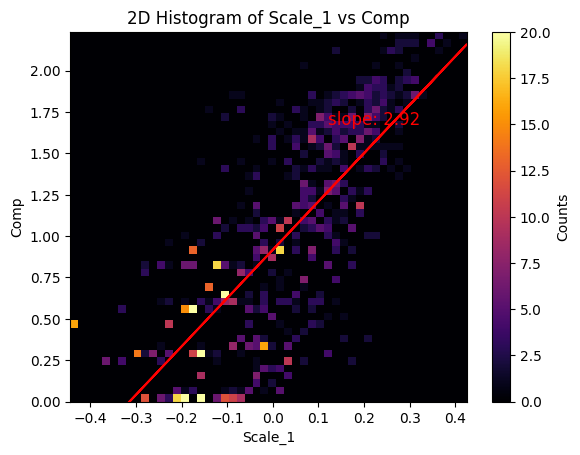

In [35]:
import matplotlib.pyplot as plt

# Assuming dataset_50y is already defined and has the necessary data
x = dataset_50y.scv_imputed['Scale_1']/10
y = dataset_50y.scv_imputed['Comp']

# Create a 2D histogram plot
plt.hist2d(x, y, bins=50, cmap='inferno')

# Add a color bar
plt.colorbar(label='Counts')

# Add labels and title
plt.ylabel('Comp')
plt.xlabel('Scale_1')
plt.title('2D Histogram of Scale_1 vs Comp')
plt.clim(0,20)
# add linear regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, slope*x + intercept, color='red')
# display slope on plot
plt.text(.65, .75, f'slope: {slope:.2f}', color='red', fontsize=12, transform=plt.gca().transAxes)


# Show the plot
plt.show()

Calculate derivatives

In [36]:
polities = dataset_50y.scv_imputed.PolityName.unique()
dataset_50y.scv_imputed['ScaleDiff'] = np.nan
dataset_50y.scv_imputed['CompDiff'] = np.nan
dataset_50y.scv_imputed = dataset_50y.scv_imputed.drop_duplicates(subset=['Scale_1', 'Comp'])
for polity in polities:
    polity_df = dataset_50y.scv_imputed[dataset_50y.scv_imputed.PolityName == polity]
    polity_df = polity_df.sort_values('Year')
    dataset_50y.scv_imputed.loc[polity_df.index, 'ScaleDiff'] = polity_df['Scale_1'].diff()
    dataset_50y.scv_imputed.loc[polity_df.index, 'CompDiff'] = polity_df['Comp'].diff()

Text(0.5, 1.0, '2D Histogram of Scale_1 vs Comp')

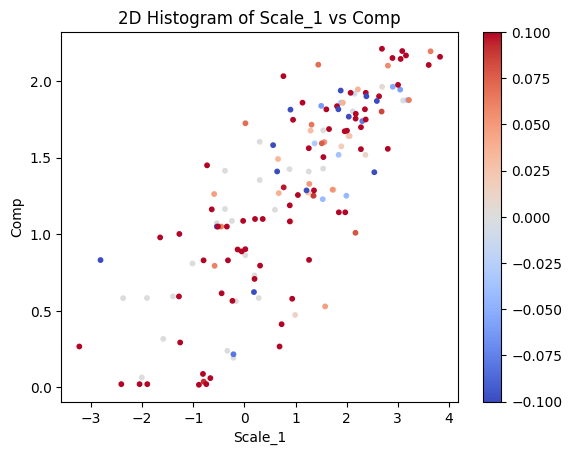

In [37]:
duration = dataset_50y.scv_imputed.groupby('PolityName').size()
duration = duration[dataset_50y.scv_imputed.PolityName].values
dataset_50y.scv_imputed['toscale'] = dataset_50y.scv_imputed['ScaleDiff'].abs()

dataset_50y.scv_imputed.sort_values('toscale', ascending=True, inplace=True)
plt.scatter(dataset_50y.scv_imputed.Scale_1, dataset_50y.scv_imputed.Comp,
            c = (dataset_50y.scv_imputed['ScaleDiff']), cmap = 'coolwarm', 
            alpha=1,s = 10, vmax = 0.1, vmin = -0.1)
plt.colorbar()
plt.ylabel('Comp')
plt.xlabel('Scale_1')
plt.title('2D Histogram of Scale_1 vs Comp')

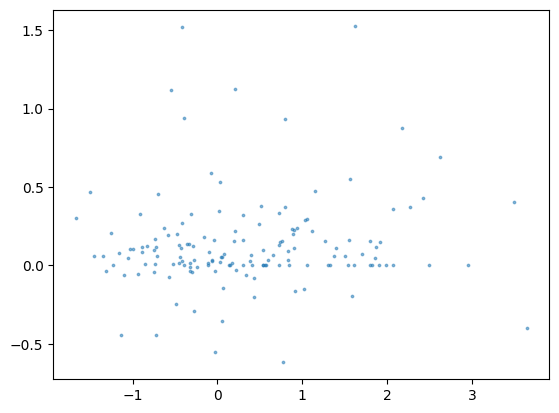

In [44]:
plt.scatter(dataset_50y.scv_imputed.Comp-dataset_50y.scv_imputed.Scale_1, dataset_50y.scv_imputed.ScaleDiff, alpha=0.5,s = 3)

In [11]:
dataset_50y.scv_imputed[['Scale_1', 'Comp', 'ScaleDiff']].corr()

,Scale_1,Comp,ScaleDiff
Scale_1,1.000000,-0.817412,-0.026818
Comp,-0.817412,1.000000,0.065808
ScaleDiff,-0.026818,0.065808,1.000000
